# One Hot Neural Network (OHNN): Application on Hearth Dataset

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import fede_code.torch_functions as tof
import fede_code.objects as obj
import fede_code.model_trainer as mt
import fede_code.graphics_functions as grafun
from torch.optim import AdamW, RMSprop
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## LOAD DATA, PREPROCESS AND TRAIN-TEST SPLIT

In [12]:
data_path = 'C:\\Users\\drikb\\Desktop\\CRISP\\XAI project\\nn\\data\\heart.csv'

In [13]:
headers = ['age', 'sex', 'chest_pain', 'resting_blood_pressure',
           'serum_cholestoral', 'fasting_blood_sugar', 'resting_ecg_results',
           'max_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak', "slope of the peak",
           'num_of_major_vessels', 'thal', 'heart_disease']

df_heart = pd.read_csv(data_path)

print(df_heart.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  


In [14]:
x = df_heart.drop(columns=['target'])
y = df_heart['target'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#standardize the dataset
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [15]:
train_set = mt.TrainDataset(torch.tensor(x_train, dtype=torch.float32),
                     torch.tensor(y_train, dtype=torch.float32))

test_set = mt.TrainDataset(torch.tensor(x_test, dtype=torch.float32),
                           torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


## TEST ON OVERFITTING A BLACK BOX MODEL PREDICTION TO GENERATE EXPLANATION

### FIT SVM MODEL

In [16]:
svm_clf = svm.SVC(kernel='linear')
svm_clf.fit(x_train,y_train)
predicted = svm_clf.predict(x_test)
f1_svm = f1_score(y_test,predicted)
acc_svm = accuracy_score(y_test, predicted)

print('f1 score SVM:', f1_svm)
print('accuracy SVM:', acc_svm)

f1 score SVM: 0.8316831683168315
accuracy SVM: 0.8131868131868132


We then build a dataset in which objective is SVM prediction

In [17]:
# build the dataset of predictions to perform explanation
pred_set = mt.TrainDataset(torch.tensor(x_test),
                           torch.tensor(predicted))

pred_loader = DataLoader(pred_set, batch_size=16, shuffle=True)

### FIT OHNN ON SVM PREDICTIONS

In [18]:
ohnn_model = obj.oneHotRuleNN(input_size=13,
                              num_neurons=4,
                              num_rules=8,
                              final_activation=nn.Sigmoid,
                              rule_weight_constraint=tof.getMax,
                              out_weight_constraint=tof.forcePositive,
                              dtype=torch.float32)

loss_fn = nn.BCELoss(reduction='sum')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')


trainer = mt.modelTrainer(model=ohnn_model,
                          loss_fn=loss_fn,
                          optimizer=AdamW)

trainer.train_model(train_data_loader=pred_loader,
                    num_epochs=10000,
                    device=device,
                    learning_rate=1e-5,
                    display_log='epoch')

CPU


  0%|          | 0/10000 [00:00<?, ?it/s]

Process takes around 7 minutes on standard CPU, reaching an accuracy from 92% to 97%

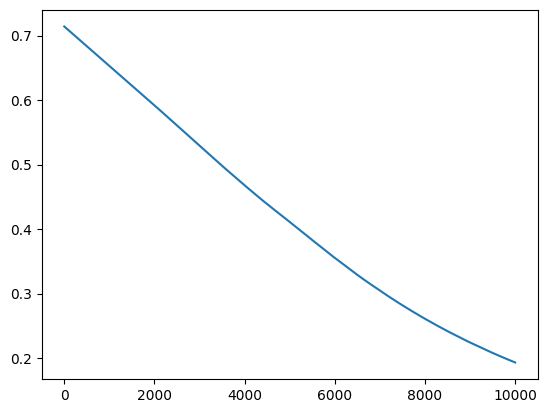

In [19]:
fig1 = sns.lineplot(trainer.history['train_loss'])
plt.show()

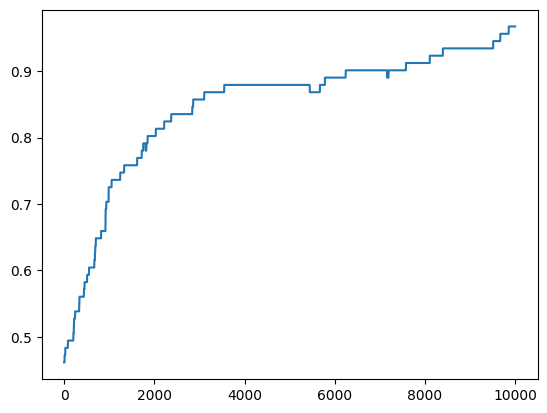

In [20]:
fig2 = sns.lineplot(trainer.history['train_accuracy'])
plt.show()

In graph below it is possible to appreciate __history of rule weight__

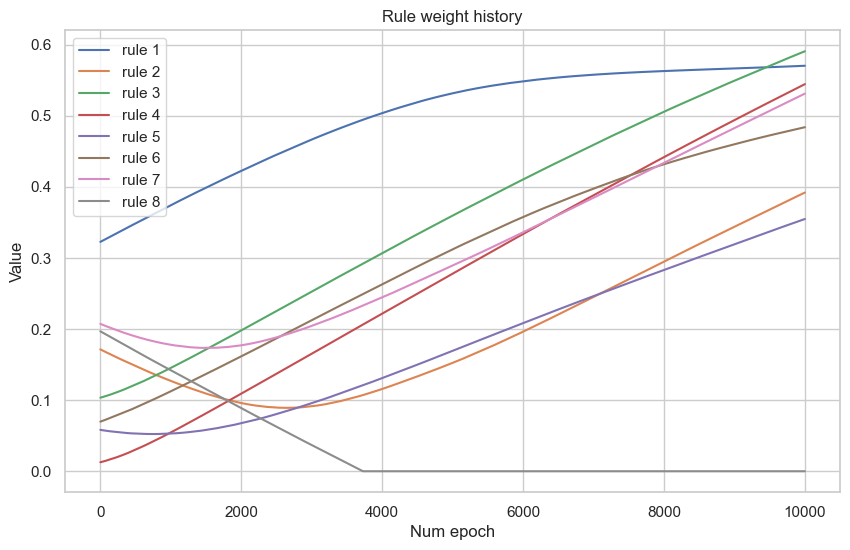

In [21]:
grafun.ruleWeightHistoryPlot(trainer.observer_history['rule_weight'])


We notice rule number 8 loose significance arounf 4000 epochs, we want to inspect deeper what happens to its parameters

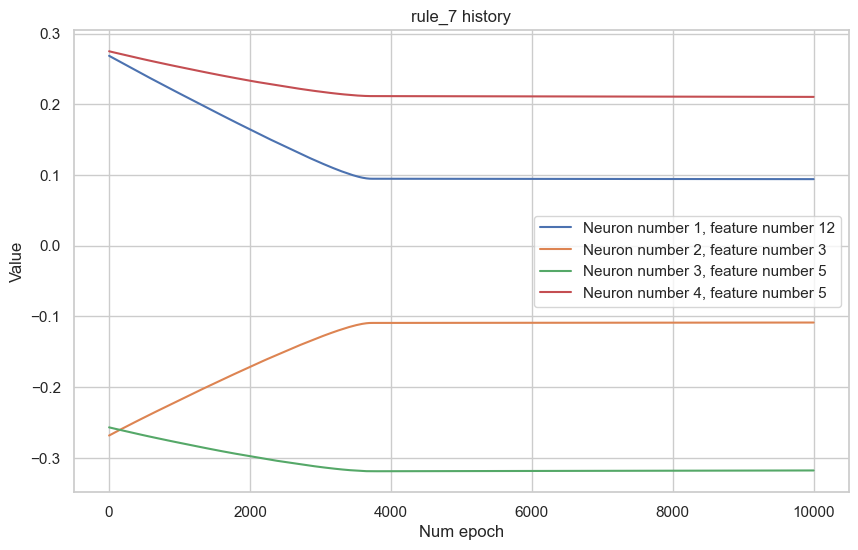

In [23]:
grafun.ruleHistoryPlot(trainer.observer_history, num_rule=7)

When significance is lost, weight training stops. The reason why it loses significance is probably it adds no useful information respect to other rules.

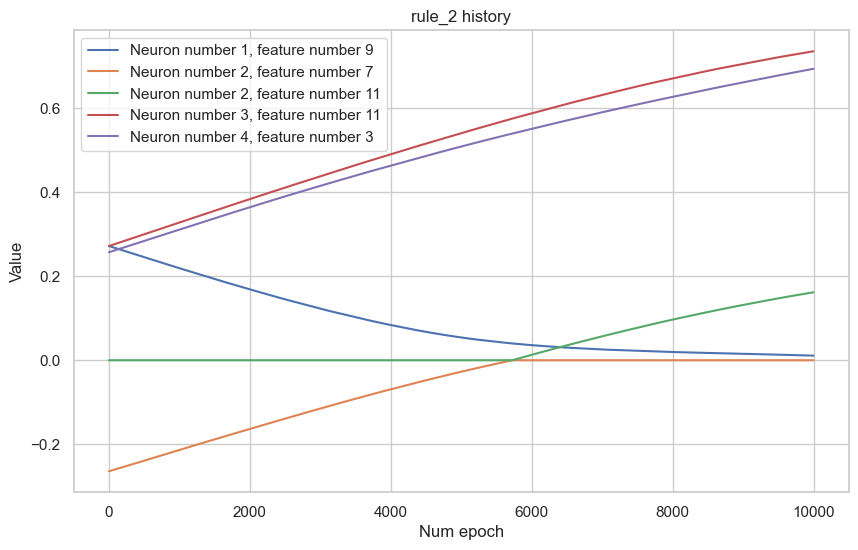

In [27]:
grafun.ruleHistoryPlot(trainer.observer_history, num_rule=2)

Here we can appreciate an example of variable shifting: weight associated to feature 7 (in orange) is sobstituted by by feature number 11 aroung 6000 epochs. It is curious to notice feature number elevent is already present in the rule (neuron 3).

As we know, it is possible to collapse this model to a linear model, we implemented a method to do so

In [30]:
linear_model = grafun.obtainLinearFormula(trainer)
print(linear_model)

tensor([-0.2163, -0.2519,  0.4099, -0.1074, -0.1171,  0.1573,  0.2490,  0.6086,
        -0.7785, -0.1232,  0.5302, -0.9079, -0.8407])


This tensor is the list of all coefficients associated to each variable

## USE OHNN TO PREDICT

It is also interesting to study predictive power of this model on the same dataset

In [31]:
ohnn_model = obj.oneHotRuleNN(input_size=13,
                              num_neurons=4,
                              num_rules=8,
                              final_activation=nn.Sigmoid,
                              rule_weight_constraint=tof.getMax,
                              out_weight_constraint=tof.forcePositive,
                              dtype=torch.float32)

loss_fn = nn.BCELoss(reduction='sum')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')


trainer = mt.modelTrainer(model=ohnn_model,
                          loss_fn=loss_fn,
                          optimizer=AdamW)

trainer.train_model(train_data_loader=train_loader,
                    num_epochs=10000,
                    device=device,
                    learning_rate=1e-5,
                    display_log='epoch')

CPU


  0%|          | 0/10000 [00:00<?, ?it/s]

Training takes around 7 minutes and reaches an accuracy from 82% to 86% on train dataset


We also want to evaluate __test performances__

In [34]:
loss, accuracy, f1_0, f1_1 = trainer.eval_model(test_loader, device='cpu')
print(f'Average loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'F1 score on label 0: {f1_0}')
print(f'F1 score on label 1: {f1_1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Average loss: 0.404795657147418
Accuracy: 0.8461538461538461
F1 score on label 0: 0.8011145942180424
F1 score on label 1: 0.8645673323092677


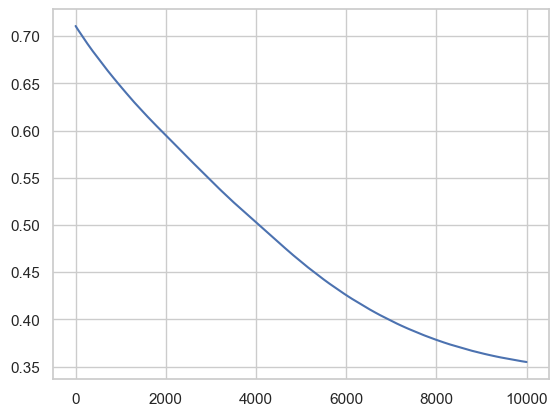

In [35]:
fig1 = sns.lineplot(trainer.history['train_loss'])
plt.show()

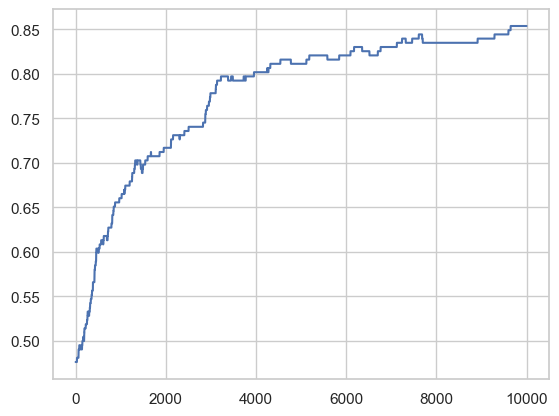

In [36]:
fig2 = sns.lineplot(trainer.history['train_accuracy'])
plt.show()

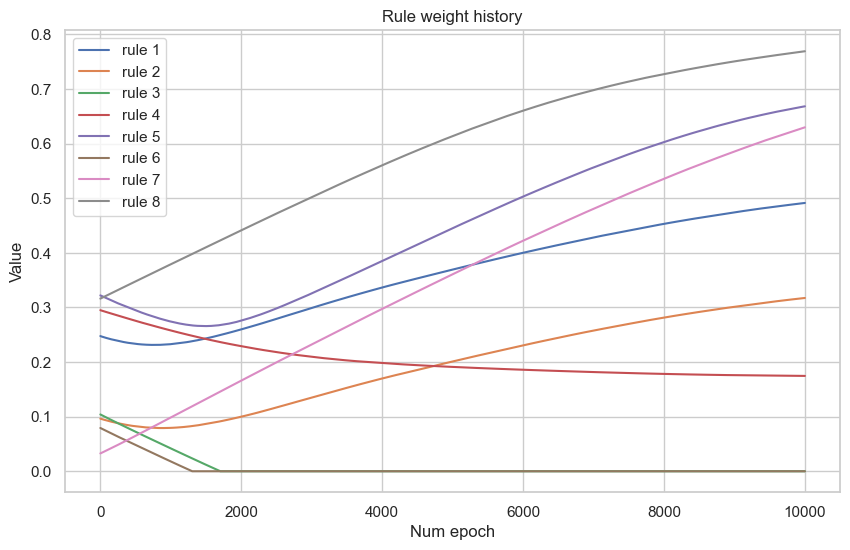

In [37]:
grafun.ruleWeightHistoryPlot(trainer.observer_history['rule_weight'])

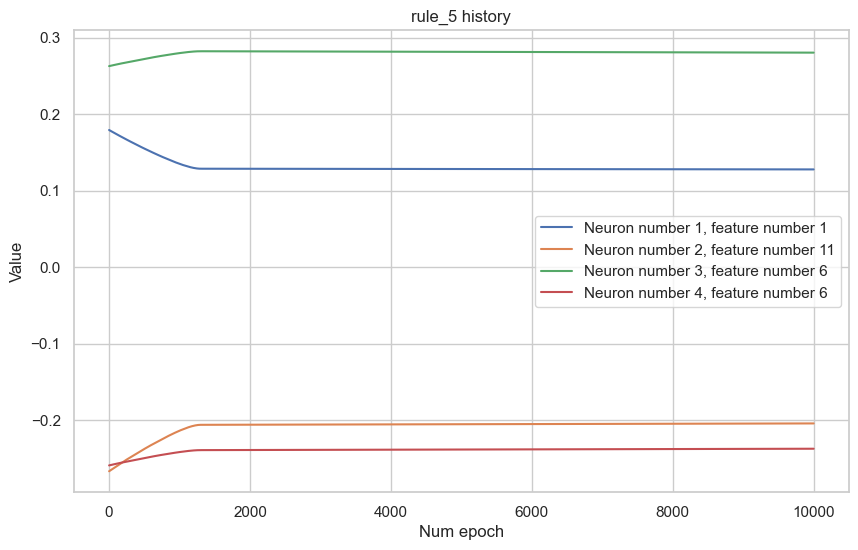

In [39]:
grafun.ruleHistoryPlot(trainer.observer_history, num_rule=5)

Again, we can reduce the model to a simple linear regression, and use it to make inference

In [40]:
linear_model = grafun.obtainLinearFormula(trainer)

out_linear = torch.matmul(torch.tensor(x_test, dtype=torch.float32), linear_model.unsqueeze(-1))
pred_linear = nn.Sigmoid()(out_linear).squeeze()
pred_linear = torch.round(pred_linear)

loss = loss_fn(pred_linear, torch.tensor(y_test, dtype=torch.float32))/len(pred_linear)

accuracy = (pred_linear == torch.tensor(y_test, dtype=torch.float32)).sum().item()/len(pred_linear)

print(loss.item())
print(accuracy)

15.384614944458008
0.8461538461538461


## PROBLEM: DOES IT LEARN MORE THAN A SIMPLE LINEAR MODEL?

We can then try to reduce this model to a simple linear regression and see whether previous specification adds something useful

In [45]:
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        self.num_rules = 0
        self.linear = nn.Linear(13, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        return self.sigmoid(x)


simple_linear = SimpleLinear()

loss_fn = nn.BCELoss(reduction='sum')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')


trainer = mt.modelTrainer(model=simple_linear,
                          loss_fn=loss_fn,
                          optimizer=AdamW)

trainer.train_model(train_data_loader=train_loader,
                    num_epochs=10000,
                    device=device,
                    learning_rate=1e-5,
                    display_log='epoch',
                   store_weights_history=False,
                   store_weights_grad=False)

CPU


  0%|          | 0/10000 [00:00<?, ?it/s]

In [46]:
loss, accuracy, f1_0, f1_1 = trainer.eval_model(test_loader, device='cpu')
print(f'Average loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'F1 score on label 0: {f1_0}')
print(f'F1 score on label 1: {f1_1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Average loss: 0.42956321842067846
Accuracy: 0.8131868131868132
F1 score on label 0: 0.7844086021505378
F1 score on label 1: 0.8275401069518716


We can see performances are comparable